<a href="https://colab.research.google.com/github/Dedalus1982/MIPHI_Kurs_Classik_ML/blob/main/Kurs_classic_DAF_IC50_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка и подготовка данных:

In [ ]:
!pip install catboost -q
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 10.5 MB/s eta 0:00:00


In [ ]:
# Подключение к Google Drive и работа с файлами
from google.colab import drive
drive.mount('/content/drive')

# Библиотеки для работы с данными
import pandas as pd
import numpy as np

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_contour

# Статистические методы
from scipy.stats import mannwhitneyu

# Машинное обучение
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Регрессоры
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                             GradientBoostingClassifier, HistGradientBoostingClassifier)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Метрики
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report)

import joblib
from pickle import TRUE
import os
import optuna

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'
handmade_df = pd.read_csv(os.path.join(data_dir,'df_handmade.csv')).drop(columns=['CC50', 'SI'])
pca_cleaned_IC50 = pd.read_csv(os.path.join(data_dir,'pca_cleaned_IC50.csv'))
tsne_cleaned_IC50 = pd.read_csv(os.path.join(data_dir,'tsne_cleaned_IC50.csv'))
umap_cleaned_IC50 = pd.read_csv(os.path.join(data_dir,'umap_cleaned_IC50.csv'))

In [ ]:
# @title Подготовка данных для моделирования
# подготовка данных для handmade_df
median = []
median = handmade_df['IC50'].median()
handmade_df['target'] = (handmade_df['IC50'] > median).astype(int)
X1 = handmade_df.drop(columns=['IC50', 'target'])
y1 = handmade_df['target']
dataframe_name_1 = 'df_handmade'
metod_name_1 = 'df_handmade'
csv_file_1 = 'results_handmade_df_IC50_classification.csv'

# подготовка данных для pca_cleaned_IC50
median = []
median = pca_cleaned_IC50['IC50'].median()
pca_cleaned_IC50['target'] = (pca_cleaned_IC50['IC50'] > median).astype(int)
X2 = pca_cleaned_IC50.drop(columns=['IC50', 'target'])
y2 = pca_cleaned_IC50['target']
dataframe_name_2 = 'cleaned_IC50'
metod_name_2 = 'PCA'
csv_file_2 = 'results_pca_cleaned_IC50_classification.csv'

# подготовка данных для tsne_cleaned_IC50
median = []
median = tsne_cleaned_IC50['IC50'].median()
tsne_cleaned_IC50['target'] = (tsne_cleaned_IC50['IC50'] > median).astype(int)
X3 = tsne_cleaned_IC50.drop(columns=['IC50', 'target'])
y3 = tsne_cleaned_IC50['target']
dataframe_name_3 = 'cleaned_IC50'
metod_name_3 = 'tSNE'
csv_file_3 = 'results_tsne_cleaned_IC50_classification.csv'

# подготовка данных для umap_cleaned_IC50
median = []
median = umap_cleaned_IC50['IC50'].median()
umap_cleaned_IC50['target'] = (umap_cleaned_IC50['IC50'] > median).astype(int)
X4 = umap_cleaned_IC50.drop(columns=['IC50', 'target'])
y4 = umap_cleaned_IC50['target']
dataframe_name_4 = 'cleaned_IC50'
metod_name_4 = 'UMAP'
csv_file_4 = 'results_umap_cleaned_IC50_classification.csv'

# название файла с хранением всех результатов
csv_file_final = 'class_results_IC50.csv'

# МОДЕЛИРОВАНИЕ

In [ ]:
# @title класс ClassificationModelEvaluator для анализа моделей
class ClassificationModelEvaluator:
    def __init__(self, X, y, test_size=0.2, random_state=42):
        """Инициализация класса для оценки классификационных моделей"""
        self.X = X.copy()
        self.y = y.copy()
        self.test_size = test_size
        self.random_state = random_state
        self.models = {}
        self.results = None
        self.best_model = None

        # Разделение данных
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y,
            test_size=test_size,
            random_state=random_state,
            stratify=self.y
        )

        self._initialize_models()

    def _initialize_models(self):
        """Инициализация моделей с параметрами"""
        self.models = {
            'LogisticRegression': {
                'model': make_pipeline(
                    StandardScaler(),
                    LogisticRegression(max_iter=2000)
                ),
                'params': {
                    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
                    'logisticregression__penalty': ['l2'],
                    'logisticregression__solver': ['lbfgs', 'liblinear', 'saga']
                }
            },
            'SVC': {
                'model': make_pipeline(
                    StandardScaler(),
                    SVC(probability=True)
                ),
                'params': {
                    'svc__C': [0.1, 1, 10],
                    'svc__kernel': ['linear', 'rbf'],
                    'svc__gamma': ['scale', 'auto']
                }
            },
            'KNN': {
                'model': make_pipeline(
                    StandardScaler(),
                    KNeighborsClassifier()
                ),
                'params': {
                    'kneighborsclassifier__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                    'kneighborsclassifier__weights': ['uniform', 'distance'],
                    'kneighborsclassifier__p': [1, 2]
                }
            },
            'DecisionTree': {
                'model': DecisionTreeClassifier(random_state=self.random_state),
                'params': {
                    'max_depth': [None, 3, 5, 7, 10, 20, 30],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4]
                }
            },
            'RandomForest': {
                'model': RandomForestClassifier(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [None, 3, 5, 7, 10, 20, 30],
                    'min_samples_split': [2, 5, 10],
                    'max_features': ['sqrt', 'log2']
                }
            },
            'ExtraTrees': {
                'model': ExtraTreesClassifier(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [None, 3, 5, 7, 10, 20, 30],
                    'min_samples_split': [2, 5, 10]
                }
            },
            'GradientBoosting': {
                'model': GradientBoostingClassifier(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'max_depth': [3, 5, 7, 10, 20, 30],
                    'min_samples_split': [2, 5, 10]
                }
            },
            'HistGradientBoosting': {
                'model': HistGradientBoostingClassifier(random_state=self.random_state),
                'params': {
                    'max_iter': [100, 200, 300],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'max_depth': [3, 5, 7, 10, 20, 30],
                    'min_samples_leaf': [10, 20]
                }
            },
            'XGBoost': {
                'model': XGBClassifier(random_state=self.random_state, eval_metric='logloss'),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'max_depth': [3, 5, 7, 10, 20, 30],
                    'subsample': [0.8, 1.0],
                    'colsample_bytree': [0.8, 1.0]
                }
            },
            'CatBoost': {
                'model': CatBoostClassifier(random_state=self.random_state, silent=True),
                'params': {
                    'iterations': [100, 200, 300],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'depth': [3, 5, 7, 10],
                    'l2_leaf_reg': [3, 5]
                }
            }
        }

    def evaluate_models(self, verbose=False):
        """Оценка всех моделей с подбором гиперпараметров"""
        results = []

        for name, model_info in self.models.items():
            if verbose:
                print(f"\n{'='*50}")
                print(f"Processing {name}...")

            model = model_info['model']
            params = model_info['params']

            # Подбор параметров через GridSearchCV
            gs = GridSearchCV(
                model,
                params,
                cv=5,
                scoring='roc_auc',
                n_jobs=-1,
                verbose=1
            )
            gs.fit(self.X_train, self.y_train)

            # Лучшая модель
            best_model = gs.best_estimator_
            best_params = gs.best_params_
            cv_score = gs.best_score_

            if verbose:
                print(f"Best params: {best_params}")

            # Предсказания
            y_pred = best_model.predict(self.X_test)
            y_proba = best_model.predict_proba(self.X_test)[:, 1]

            # Метрики
            metrics = {
                'Model': name,
                'Best Parameters': best_params,
                'CV ROC AUC': cv_score,
                'Test Accuracy': accuracy_score(self.y_test, y_pred),
                'Test Precision': precision_score(self.y_test, y_pred),
                'Test Recall': recall_score(self.y_test, y_pred),
                'Test F1': f1_score(self.y_test, y_pred),
                'Test ROC AUC': roc_auc_score(self.y_test, y_proba),
                'Confusion Matrix': confusion_matrix(self.y_test, y_pred),
                'Classification Report': classification_report(self.y_test, y_pred, output_dict=True)
            }

            results.append(metrics)

            if verbose:
                print(f"Completed: Test ROC AUC: {metrics['Test ROC AUC']:.3f}")

            # Сохраняем лучшую модель
            if self.best_model is None or metrics['Test ROC AUC'] > self.best_model[1]:
                self.best_model = (best_model, metrics['Test ROC AUC'])

        # Сохраняем результаты
        self.results = pd.DataFrame(results)
        self.results.set_index('Model', inplace=True)
        self.results = self.results.sort_values('Test ROC AUC', ascending=False)

        return self.results

    def get_best_model(self):
        """Возвращает лучшую модель с метриками"""
        if self.best_model is None:
            raise ValueError("Сначала выполните evaluate_models()")
        return self.best_model[0]

    def predict(self, X, return_proba=False):
        """Предсказание с использованием лучшей модели"""
        if self.best_model is None:
            raise ValueError("Сначала выполните evaluate_models()")

        if return_proba:
            return self.best_model[0].predict_proba(X)
        return self.best_model[0].predict(X)

    def get_feature_importances(self):
        """Возвращает важность признаков для моделей, где это применимо"""
        if self.best_model is None:
            raise ValueError("Сначала выполните evaluate_models()")

        model = self.best_model[0]

        if hasattr(model, 'feature_importances_'):
            # Для ансамблевых моделей и деревьев
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            # Для линейных моделей
            importances = model.coef_[0]
        else:
            raise ValueError("Модель не поддерживает атрибут важности признаков")

        return pd.DataFrame({
            'Feature': self.X.columns,
            'Importance': importances
        }).sort_values('Importance', ascending=False)

    def save_model(self, model_name=None, filename='model.pkl',
                  data_dir='/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'):
        """
        Сохраняет указанную модель в файл
        """
        if not hasattr(self, 'results'):
            raise ValueError("Сначала выполните evaluate_models()")

        filepath = os.path.join(data_dir, filename)
        os.makedirs(data_dir, exist_ok=True)

        if model_name is None:
            model = self.best_model[0]
            print(f"Лучшая модель ({model.__class__.__name__}) сохранена в {filepath}")
        else:
            if model_name not in self.results.index:
                raise ValueError(f"Модель {model_name} не найдена. Доступные модели: {list(self.results.index)}")

            best_params = self.results.loc[model_name, 'Best Parameters']
            model = self.models[model_name]['model'].set_params(**best_params)
            model.fit(self.X_train, self.y_train)
            print(f"Модель {model_name} сохранена в {filepath}")

        joblib.dump(model, filepath)

In [ ]:
# @title Класс ClassificationResultsVisualizer для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
import numpy as np

class ClassificationResultsVisualizer:
    def __init__(self, evaluator, results_df):
        self.evaluator = evaluator
        self.results_df = results_df
        self.best_model_name = results_df.index[0]

        # Настройка стиля графиков
        sns.set_style("whitegrid")
        self.colors = sns.color_palette("husl")
        plt.rcParams['figure.facecolor'] = 'white'

    def plot_metrics_comparison(self, metrics=None, ax=None):
        if metrics is None:
            metrics = ['Test ROC AUC', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1']

        plot_df = self.results_df[metrics].sort_values(metrics[0], ascending=True)
        colors = self.colors[:len(metrics)]
        plot_df.plot(kind='barh', width=0.8, color=colors, ax=ax, legend=False)    # выключили легенду

        ax.set_title('Сравнение метрик', fontsize=13)
        ax.set_xlabel('Значение метрики', fontsize=11)
        ax.set_ylabel('Модель', fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.legend(metrics, loc='lower right', fontsize=8)

    def plot_roc_curves(self, top_n=10, ax=None):
        for i, model_name in enumerate(self.results_df.index[:top_n]):
            roc_auc = self.results_df.loc[model_name, 'Test ROC AUC']
            model_info = self.evaluator.models[model_name]
            model = model_info['model'].fit(self.evaluator.X_train, self.evaluator.y_train)
            y_proba = model.predict_proba(self.evaluator.X_test)[:, 1]
            fpr, tpr, _ = roc_curve(self.evaluator.y_test, y_proba)
            ax.plot(fpr, tpr, lw=2,
                    label=f'{model_name} (AUC = {roc_auc:.2f})',
                    color=self.colors[i % len(self.colors)])
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=11)
        ax.set_ylabel('True Positive Rate', fontsize=11)
        ax.set_title(f'ROC-кривые топ-{top_n} моделей', fontsize=13)
        ax.legend(loc="lower right", fontsize=8)
        ax.grid(True, alpha=0.3)

    def plot_confusion_matrix(self, ax=None):
        best_model_pred = self.evaluator.predict(self.evaluator.X_test)
        cm = confusion_matrix(self.evaluator.y_test, best_model_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Низкий IC50', 'Высокий IC50'],
                    yticklabels=['Низкий IC50', 'Высокий IC50'],
                    ax=ax)
        ax.set_title(f'Матрица ошибок ({self.best_model_name})', fontsize=13)
        ax.set_ylabel('Истинный класс', fontsize=11)
        ax.set_xlabel('Предсказанный класс', fontsize=11)

    def plot_precision_recall_curve(self, ax=None):
        y_proba = self.evaluator.predict(self.evaluator.X_test, return_proba=True)[:, 1]
        precision, recall, _ = precision_recall_curve(self.evaluator.y_test, y_proba)
        average_precision = average_precision_score(self.evaluator.y_test, y_proba)
        ax.plot(recall, precision, color=self.colors[2], lw=2,
                label=f'AP = {average_precision:.2f}')
        ax.set_xlabel('Recall', fontsize=11)
        ax.set_ylabel('Precision', fontsize=11)
        ax.set_title(f'Precision-Recall кривая ({self.best_model_name})', fontsize=13)
        ax.legend(loc="upper right", fontsize=8)
        ax.grid(True, alpha=0.3)

    def visualize_all(self):
        # 2 строки, 2 столбца
        fig, axes = plt.subplots(2, 2, figsize=(17, 13))
        plt.subplots_adjust(hspace=0.3, wspace=0.2)

        self.plot_metrics_comparison(ax=axes[0, 0])
        self.plot_roc_curves(ax=axes[0, 1])
        self.plot_confusion_matrix(ax=axes[1, 0])
        self.plot_precision_recall_curve(ax=axes[1, 1])

        plt.show()


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 52 candidates, totalling 260 fits
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fitting 5 folds for each of 126 candidates, totalling 630 fits
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits


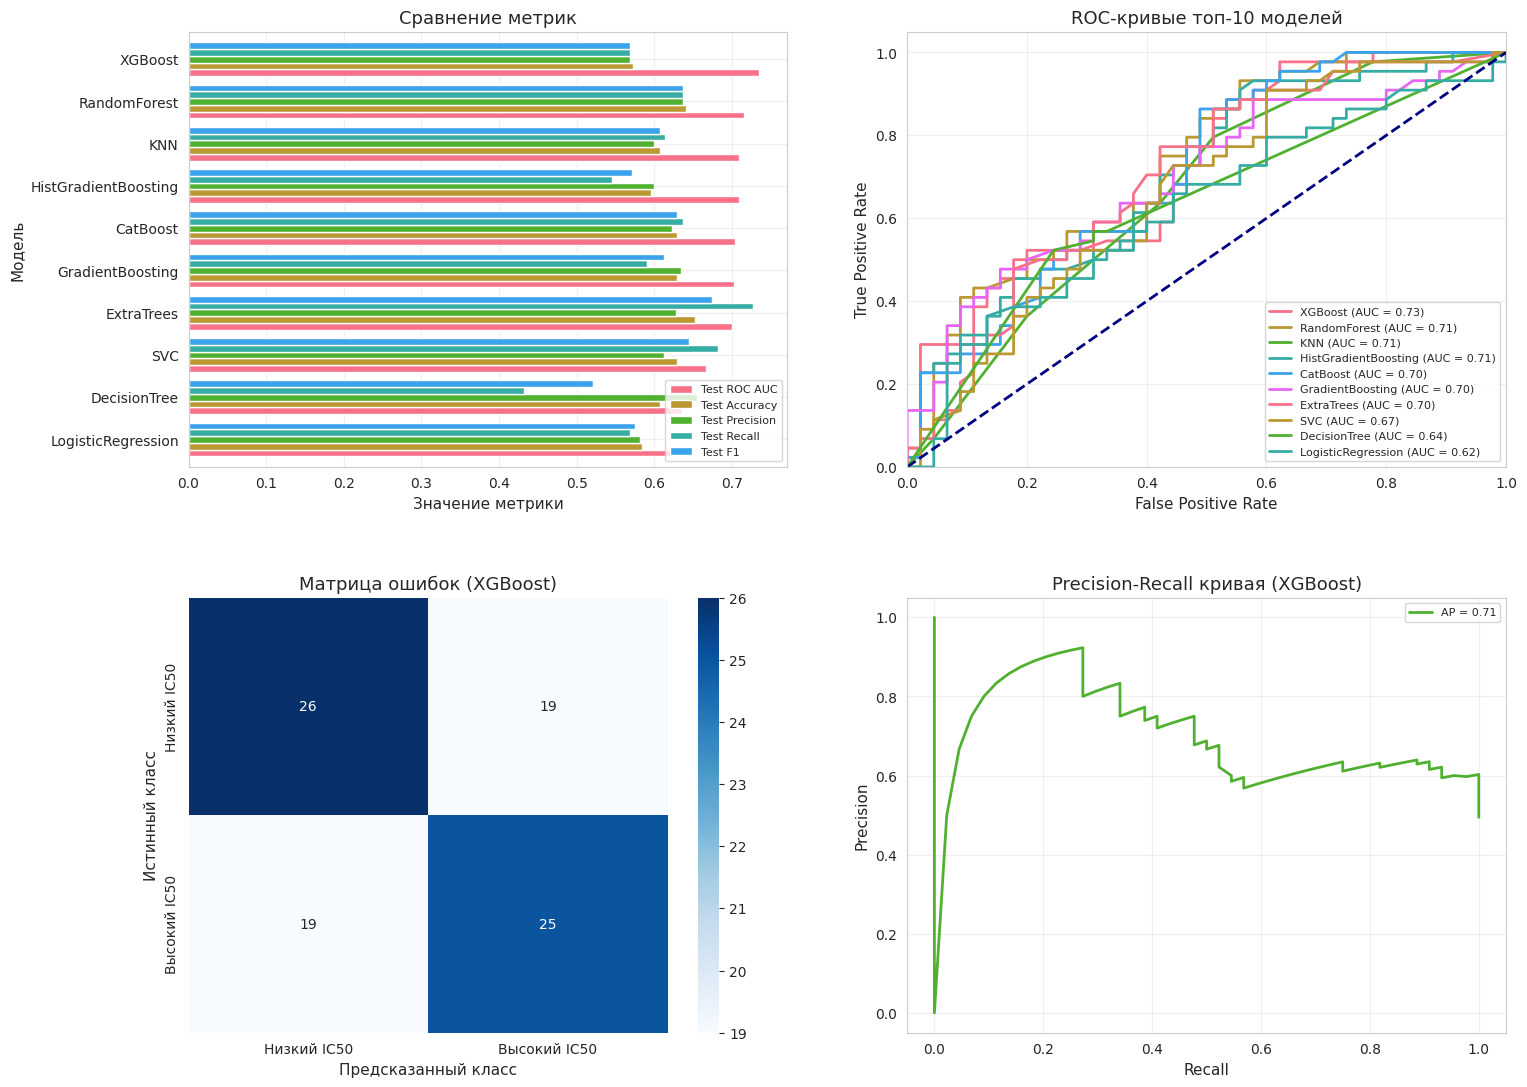

In [ ]:
# @title Тест моделей на ручных данных
# Инициализация
evaluator_handmade_df = ClassificationModelEvaluator(X1, y1, test_size=0.2)

# Оценка моделей
results = evaluator_handmade_df.evaluate_models()

# создаем таблицу с промежуточным результатом для итогового сравнения моделей
results_handmade_df = results.copy()
results_handmade_df['dataframe'] = dataframe_name_1
results_handmade_df['metod'] = metod_name_1
columns_order = ['dataframe', 'metod'] + [col for col in results.columns]
results_handmade_df = results_handmade_df[columns_order]

# Получение лучшей модели
best_model = evaluator_handmade_df.get_best_model()

# Предсказания (автоматически преобразуются обратно из логарифмической шкалы)
predictions = evaluator_handmade_df.predict(X1)
predictions_handmade_df = predictions

# Сохраненние результата
results_handmade_df_id = results_handmade_df.reset_index()
results_handmade_df_id.to_csv(os.path.join(data_dir, csv_file_1), index=False)

# Диаграмки
visualizer = ClassificationResultsVisualizer(evaluator_handmade_df, results_df = results_handmade_df)
visualizer.visualize_all()

In [ ]:
results_handmade_df.head(5)

,dataframe,metod,Best Parameters,CV ROC AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC,Confusion Matrix,Classification Report
Model,,,,,,,,,,,
XGBoost,df_handmade,df_handmade,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.701351,0.573034,0.568182,0.568182,0.568182,0.734596,"[[26, 19], [19, 25]]","{'0': {'precision': 0.5777777777777777, 'recal..."
RandomForest,df_handmade,df_handmade,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.704934,0.640449,0.636364,0.636364,0.636364,0.714899,"[[29, 16], [16, 28]]","{'0': {'precision': 0.6444444444444445, 'recal..."
KNN,df_handmade,df_handmade,"{'kneighborsclassifier__n_neighbors': 3, 'knei...",0.687444,0.606742,0.600000,0.613636,0.606742,0.709596,"[[27, 18], [17, 27]]","{'0': {'precision': 0.6136363636363636, 'recal..."
HistGradientBoosting,df_handmade,df_handmade,"{'learning_rate': 0.05, 'max_depth': 7, 'max_i...",0.694302,0.595506,0.600000,0.545455,0.571429,0.708838,"[[29, 16], [20, 24]]","{'0': {'precision': 0.5918367346938775, 'recal..."
CatBoost,df_handmade,df_handmade,"{'depth': 10, 'iterations': 100, 'l2_leaf_reg'...",0.715714,0.629213,0.622222,0.636364,0.629213,0.704293,"[[28, 17], [16, 28]]","{'0': {'precision': 0.6363636363636364, 'recal..."


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 52 candidates, totalling 260 fits
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fitting 5 folds for each of 126 candidates, totalling 630 fits
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits


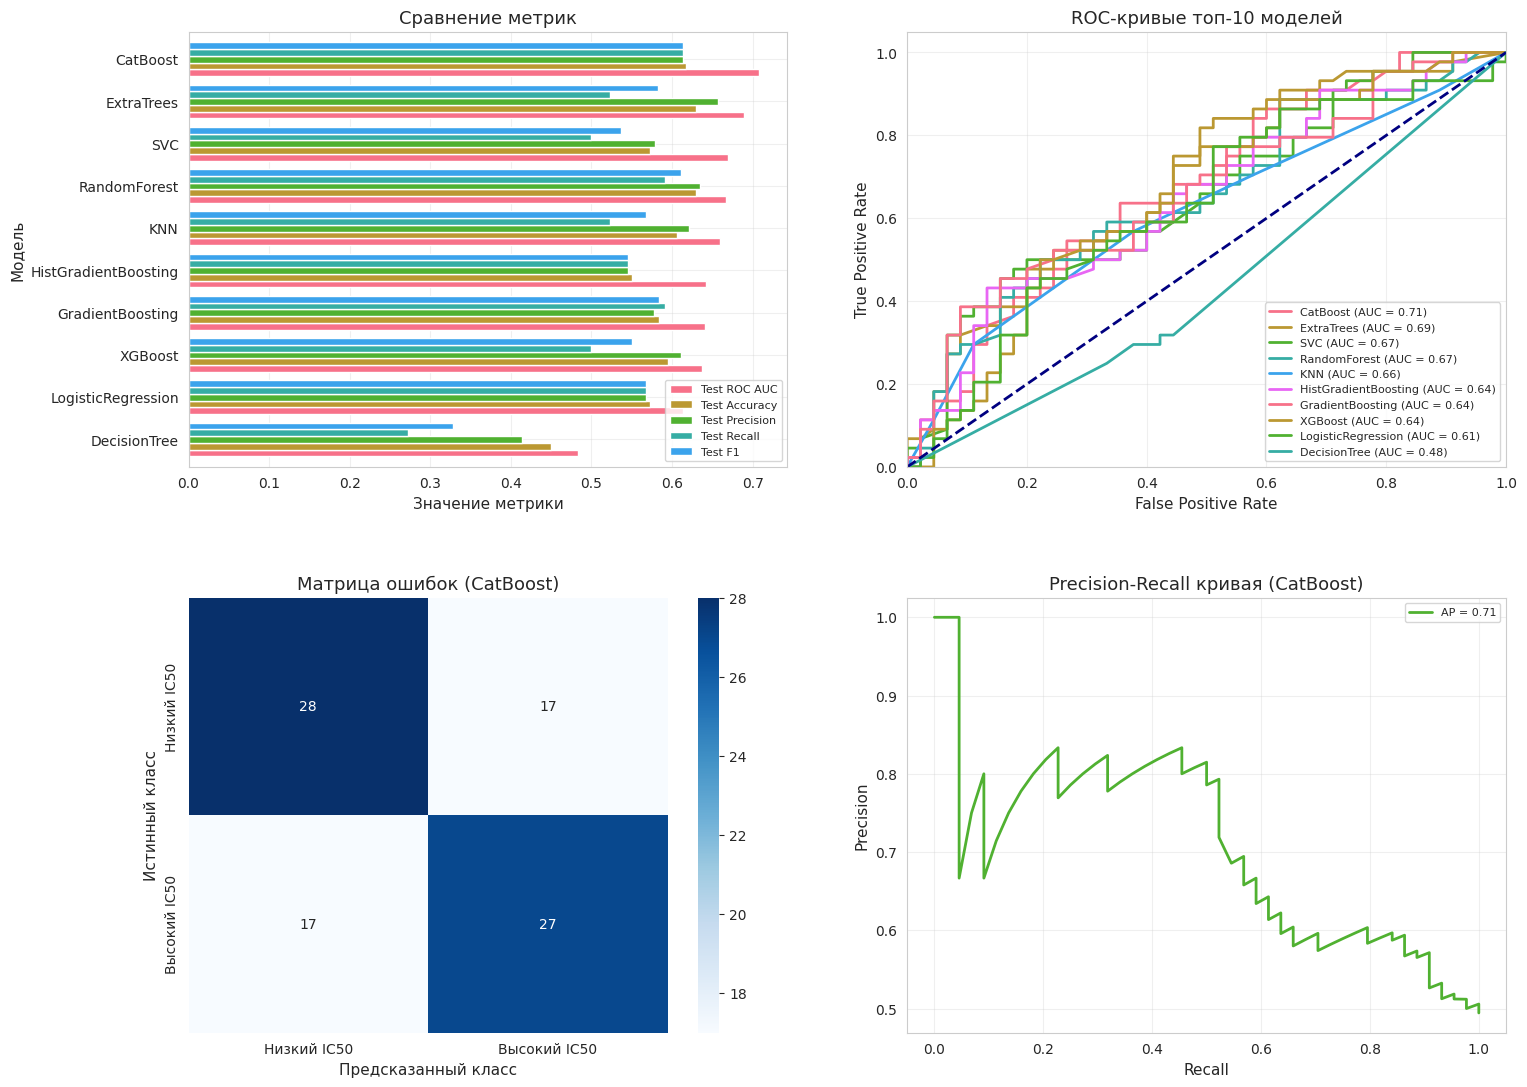

In [ ]:
# @title Тест моделей на ОЧИЩЕННЫХ от выбросов даннык, масштабированных PCA(50 параметров)
# Инициализация
evaluator_pca_cleaned = ClassificationModelEvaluator(X2, y2, test_size=0.2)

# Оценка моделей
results = evaluator_pca_cleaned.evaluate_models()

# создаем таблицу с промежуточным результатом для итогового сравнения моделей
results_pca_cleaned = results.copy()
results_pca_cleaned['dataframe'] = dataframe_name_2
results_pca_cleaned['metod'] = metod_name_2
columns_order = ['dataframe', 'metod'] + [col for col in results.columns]
results_pca_cleaned = results_pca_cleaned[columns_order]

# Получение лучшей модели
best_model = evaluator_pca_cleaned.get_best_model()

# Предсказания (автоматически преобразуются обратно из логарифмической шкалы)
predictions = evaluator_pca_cleaned.predict(X2)
predictions_pca_cleaned = predictions

# Сохраненние результата
results_pca_cleaned_id = results_pca_cleaned.reset_index()
results_pca_cleaned_id.to_csv(os.path.join(data_dir, csv_file_2), index=False)

visualizer = ClassificationResultsVisualizer(evaluator_pca_cleaned, results_df = results_pca_cleaned)
visualizer.visualize_all()

In [ ]:
results_pca_cleaned.head(5)

,dataframe,metod,Best Parameters,CV ROC AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC,Confusion Matrix,Classification Report
Model,,,,,,,,,,,
CatBoost,cleaned_IC50,PCA,"{'depth': 7, 'iterations': 300, 'l2_leaf_reg':...",0.695029,0.617978,0.613636,0.613636,0.613636,0.707828,"[[28, 17], [17, 27]]","{'0': {'precision': 0.6222222222222222, 'recal..."
ExtraTrees,cleaned_IC50,PCA,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",0.692512,0.629213,0.657143,0.522727,0.582278,0.689646,"[[33, 12], [21, 23]]","{'0': {'precision': 0.6111111111111112, 'recal..."
SVC,cleaned_IC50,PCA,"{'svc__C': 10, 'svc__gamma': 'scale', 'svc__ke...",0.699374,0.573034,0.578947,0.500000,0.536585,0.669192,"[[29, 16], [22, 22]]","{'0': {'precision': 0.5686274509803921, 'recal..."
RandomForest,cleaned_IC50,PCA,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",0.692476,0.629213,0.634146,0.590909,0.611765,0.666919,"[[30, 15], [18, 26]]","{'0': {'precision': 0.625, 'recall': 0.6666666..."
KNN,cleaned_IC50,PCA,"{'kneighborsclassifier__n_neighbors': 13, 'kne...",0.677558,0.606742,0.621622,0.522727,0.567901,0.659596,"[[31, 14], [21, 23]]","{'0': {'precision': 0.5961538461538461, 'recal..."


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 52 candidates, totalling 260 fits
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fitting 5 folds for each of 126 candidates, totalling 630 fits
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits


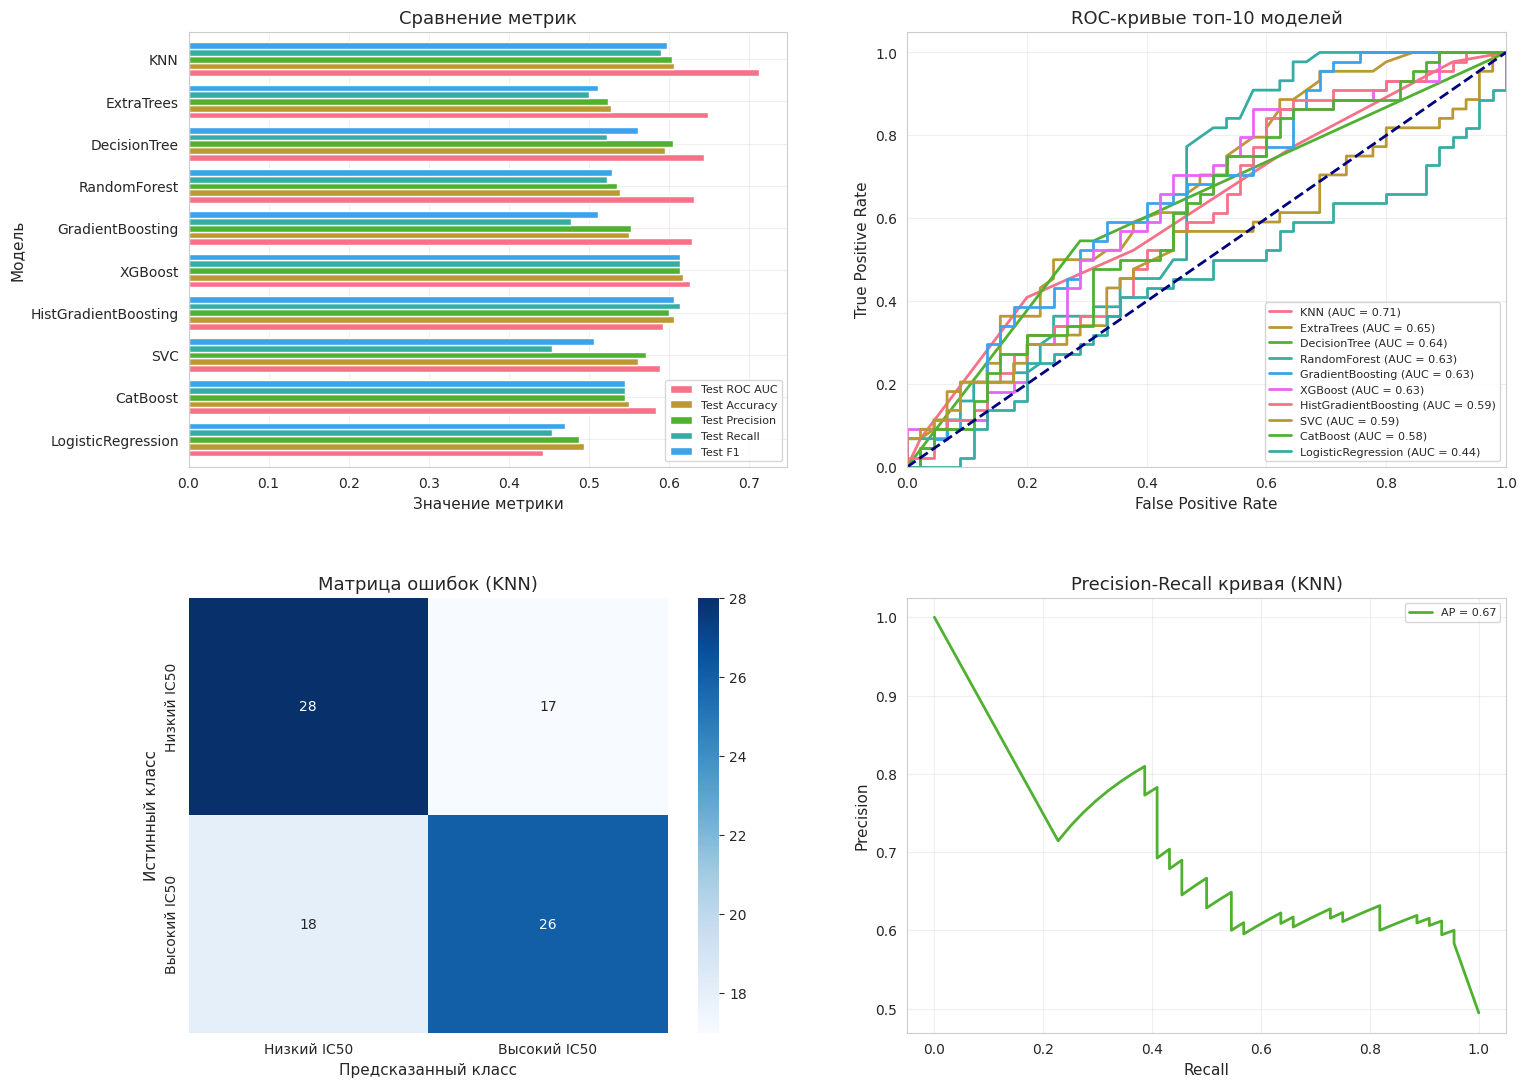

In [ ]:
# @title Тест моделей на ОЧИЩЕННЫХ от выбросов даннык, масштабированных tSNE
# Инициализация
evaluator_tsne_cleaned = ClassificationModelEvaluator(X3, y3, test_size=0.2)

# Оценка моделей
results = evaluator_tsne_cleaned.evaluate_models()

# создаем таблицу с промежуточным результатом для итогового сравнения моделей
results_tsne_cleaned = results.copy()
results_tsne_cleaned['dataframe'] = dataframe_name_3
results_tsne_cleaned['metod'] = metod_name_3
columns_order = ['dataframe', 'metod'] + [col for col in results.columns]
results_tsne_cleaned = results_tsne_cleaned[columns_order]

# Получение лучшей модели
best_model = evaluator_tsne_cleaned.get_best_model()

# Предсказания (автоматически преобразуются обратно из логарифмической шкалы)
predictions = evaluator_tsne_cleaned.predict(X3)
predictions_tsne_cleaned = predictions

# Сохраненние результата
results_tsne_cleaned_id = results_tsne_cleaned.reset_index()
results_tsne_cleaned_id.to_csv(os.path.join(data_dir, csv_file_3), index=False)

visualizer = ClassificationResultsVisualizer(evaluator_tsne_cleaned, results_df = results_tsne_cleaned)
visualizer.visualize_all()

In [ ]:
results_tsne_cleaned.head(5)

,dataframe,metod,Best Parameters,CV ROC AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC,Confusion Matrix,Classification Report
Model,,,,,,,,,,,
KNN,cleaned_IC50,tSNE,"{'kneighborsclassifier__n_neighbors': 3, 'knei...",0.654705,0.606742,0.604651,0.590909,0.597701,0.712626,"[[28, 17], [18, 26]]","{'0': {'precision': 0.6086956521739131, 'recal..."
ExtraTrees,cleaned_IC50,tSNE,"{'max_depth': None, 'min_samples_split': 5, 'n...",0.647698,0.528090,0.523810,0.500000,0.511628,0.648485,"[[25, 20], [22, 22]]","{'0': {'precision': 0.5319148936170213, 'recal..."
DecisionTree,cleaned_IC50,tSNE,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.603374,0.595506,0.605263,0.522727,0.560976,0.644192,"[[30, 15], [21, 23]]","{'0': {'precision': 0.5882352941176471, 'recal..."
RandomForest,cleaned_IC50,tSNE,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.628161,0.539326,0.534884,0.522727,0.528736,0.631818,"[[25, 20], [21, 23]]","{'0': {'precision': 0.5434782608695652, 'recal..."
GradientBoosting,cleaned_IC50,tSNE,"{'learning_rate': 0.05, 'max_depth': 20, 'min_...",0.637728,0.550562,0.552632,0.477273,0.512195,0.629293,"[[28, 17], [23, 21]]","{'0': {'precision': 0.5490196078431373, 'recal..."


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 52 candidates, totalling 260 fits
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fitting 5 folds for each of 126 candidates, totalling 630 fits
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits


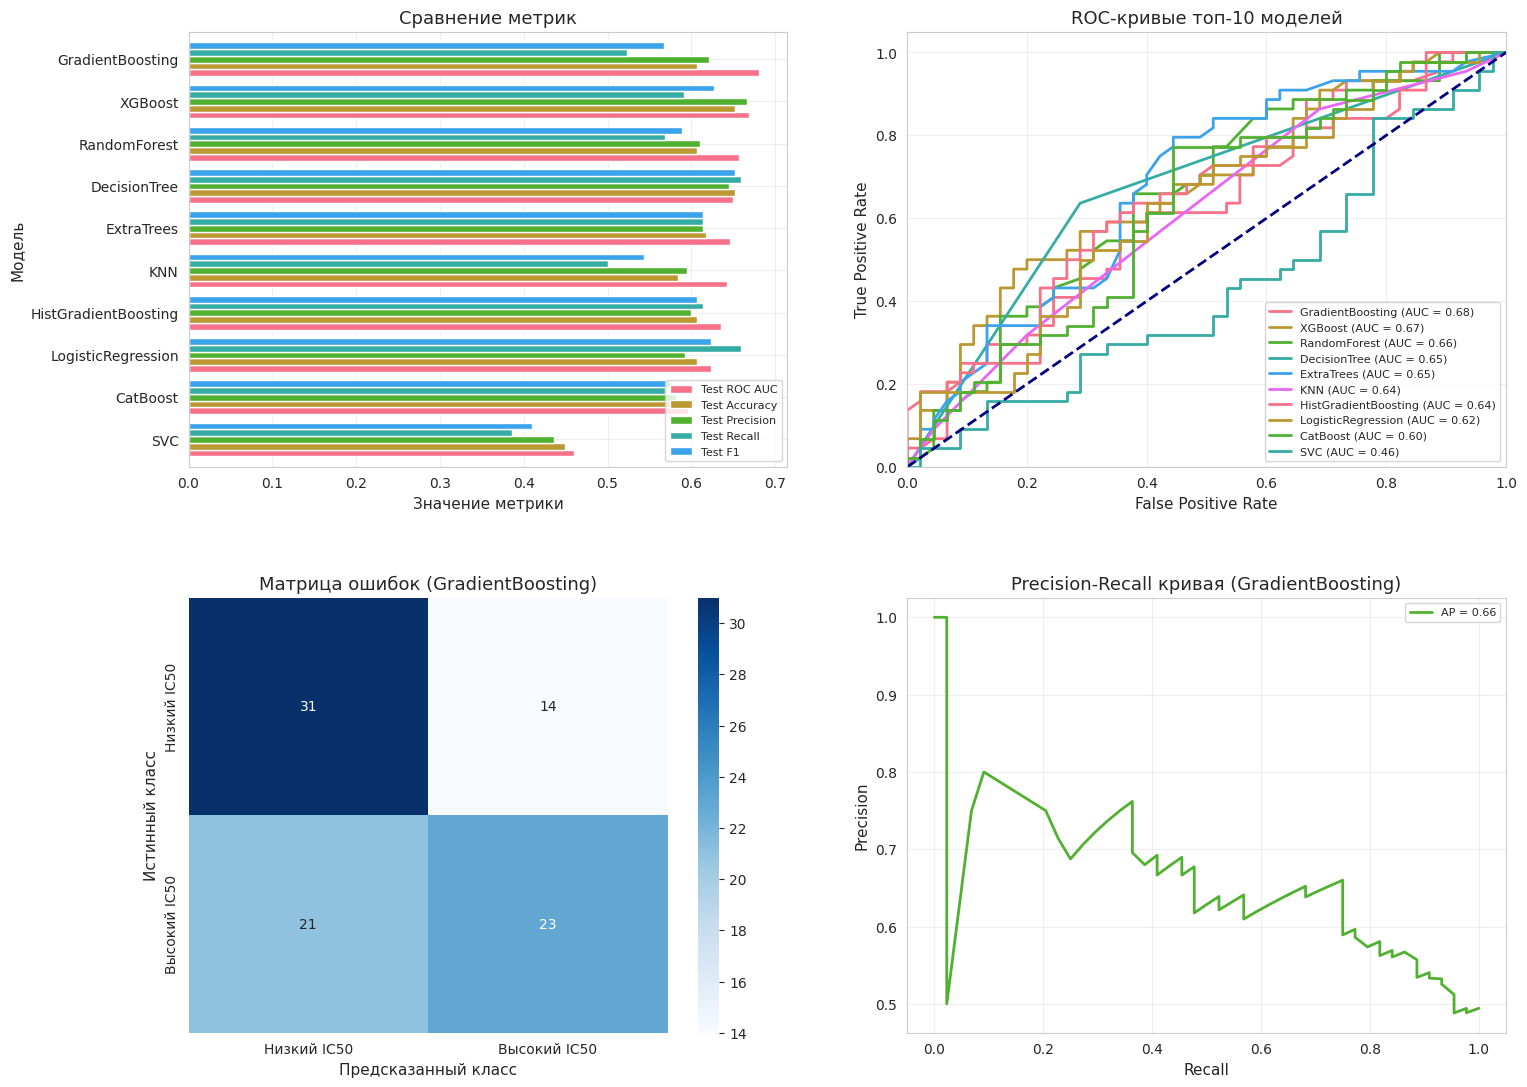

In [ ]:
# @title Тест моделей на ОЧИЩЕННЫХ от выбросов даннык, масштабированных UMAP
# Инициализация
evaluator_umap_cleaned = ClassificationModelEvaluator(X4, y4, test_size=0.2)

# Оценка моделей
results = evaluator_umap_cleaned.evaluate_models()

# создаем таблицу с промежуточным результатом для итогового сравнения моделей
results_umap_cleaned = results.copy()
results_umap_cleaned['dataframe'] = dataframe_name_4
results_umap_cleaned['metod'] = metod_name_4
columns_order = ['dataframe', 'metod'] + [col for col in results.columns]
results_umap_cleaned = results_umap_cleaned[columns_order]

# Получение лучшей модели
best_model = evaluator_umap_cleaned.get_best_model()

# Предсказания (автоматически преобразуются обратно из логарифмической шкалы)
predictions = evaluator_umap_cleaned.predict(X4)
predictions_umap_cleaned = predictions

# Сохраненние результата
results_umap_cleaned_id = results_umap_cleaned.reset_index()
results_umap_cleaned_id.to_csv(os.path.join(data_dir, csv_file_4), index=False)

visualizer = ClassificationResultsVisualizer(evaluator_umap_cleaned, results_df = results_umap_cleaned)
visualizer.visualize_all()

In [ ]:
results_umap_cleaned.head(5)

,dataframe,metod,Best Parameters,CV ROC AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC,Confusion Matrix,Classification Report
Model,,,,,,,,,,,
GradientBoosting,cleaned_IC50,UMAP,"{'learning_rate': 0.05, 'max_depth': 30, 'min_...",0.619757,0.606742,0.621622,0.522727,0.567901,0.680556,"[[31, 14], [21, 23]]","{'0': {'precision': 0.5961538461538461, 'recal..."
XGBoost,cleaned_IC50,UMAP,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.642190,0.651685,0.666667,0.590909,0.626506,0.668939,"[[32, 13], [18, 26]]","{'0': {'precision': 0.64, 'recall': 0.71111111..."
RandomForest,cleaned_IC50,UMAP,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",0.635476,0.606742,0.609756,0.568182,0.588235,0.656313,"[[29, 16], [19, 25]]","{'0': {'precision': 0.6041666666666666, 'recal..."
DecisionTree,cleaned_IC50,UMAP,"{'max_depth': None, 'min_samples_leaf': 4, 'mi...",0.587379,0.651685,0.644444,0.659091,0.651685,0.649747,"[[29, 16], [15, 29]]","{'0': {'precision': 0.6590909090909091, 'recal..."
ExtraTrees,cleaned_IC50,UMAP,"{'max_depth': 10, 'min_samples_split': 10, 'n_...",0.657088,0.617978,0.613636,0.613636,0.613636,0.646465,"[[28, 17], [17, 27]]","{'0': {'precision': 0.6222222222222222, 'recal..."


# СВОД И ВЫВОДЫ

In [ ]:
# @title Датасет со всеми результатами
# Список файлов с результатами
result_files = [csv_file_1, csv_file_2, csv_file_3, csv_file_4]

# Создаем список для хранения датафреймов
dfs = []

# Читаем каждый файл и добавляем в список
for file in result_files:
    # Полный путь к файлу
    file_path = os.path.join(data_dir, file)

    # Читаем CSV
    df = pd.read_csv(file_path)

    # Добавляем столбец с типом данных (из имени файла)
    data_type = file.split('_')[1]  # Извлекаем 'handmade', 'pca', 'tsne', 'umap'
    df['Data_Type'] = data_type

    # Добавляем в список
    dfs.append(df)

# Объединяем все датафреймы
combined_results = pd.concat(dfs, ignore_index=True)

# Сохраняем объединенный результат
combined_results.to_csv(os.path.join(data_dir, csv_file_final), index=False)

# Выводим первые строки для проверки
combined_results_for_view=combined_results.drop(['Best Parameters', 'Classification Report'], axis = 1)
combined_results_for_view = combined_results_for_view.sort_values(by='Test ROC AUC', ascending=False)
combined_results_for_view.head(10)

,Model,dataframe,metod,CV ROC AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC,Confusion Matrix,Data_Type
0,XGBoost,df_handmade,df_handmade,0.701351,0.573034,0.568182,0.568182,0.568182,0.734596,[[26 19]\n [19 25]],handmade
1,RandomForest,df_handmade,df_handmade,0.704934,0.640449,0.636364,0.636364,0.636364,0.714899,[[29 16]\n [16 28]],handmade
20,KNN,cleaned_IC50,tSNE,0.654705,0.606742,0.604651,0.590909,0.597701,0.712626,[[28 17]\n [18 26]],tsne
2,KNN,df_handmade,df_handmade,0.687444,0.606742,0.600000,0.613636,0.606742,0.709596,[[27 18]\n [17 27]],handmade
3,HistGradientBoosting,df_handmade,df_handmade,0.694302,0.595506,0.600000,0.545455,0.571429,0.708838,[[29 16]\n [20 24]],handmade
10,CatBoost,cleaned_IC50,PCA,0.695029,0.617978,0.613636,0.613636,0.613636,0.707828,[[28 17]\n [17 27]],pca
4,CatBoost,df_handmade,df_handmade,0.715714,0.629213,0.622222,0.636364,0.629213,0.704293,[[28 17]\n [16 28]],handmade
5,GradientBoosting,df_handmade,df_handmade,0.697451,0.629213,0.634146,0.590909,0.611765,0.702273,[[30 15]\n [18 26]],handmade
6,ExtraTrees,df_handmade,df_handmade,0.705245,0.651685,0.627451,0.727273,0.673684,0.700505,[[26 19]\n [12 32]],handmade
11,ExtraTrees,cleaned_IC50,PCA,0.692512,0.629213,0.657143,0.522727,0.582278,0.689646,[[33 12]\n [21 23]],pca


In [ ]:
value = combined_results.iloc[1, 3]
value

"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200}"

In [ ]:
# @title Класс ClassificationModelEvaluatorOptuna для подбора гиперпараметров трех лучших моделей
class ClassificationModelEvaluatorOptuna:
    def __init__(self, X, y, test_size=0.2, random_state=42, n_trials=100):
        self.X = X.copy()
        self.y = y.copy()
        self.test_size = test_size
        self.random_state = random_state
        self.n_trials = n_trials
        self.models = {}
        self.results = None
        self.best_model = None
        self.study = None
        self.optuna_results = {}

        # Разделение данных
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y,
            test_size=test_size,
            random_state=random_state,
            stratify=self.y
        )

        self._initialize_models()

    def _initialize_models(self):
        self.models = {
            'RandomForest': {
                'model': RandomForestClassifier(random_state=self.random_state),
                'params_func': self._rf_objective
            },
            'XGBoost': {
                'model': XGBClassifier(random_state=self.random_state, eval_metric='logloss'),
                'params_func': self._xgb_objective
            },
            'ExtraTrees': {
                'model': ExtraTreesClassifier(random_state=self.random_state),
                'params_func': self._et_objective
            }
        }

    def _rf_objective(self, trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 150, 250),
            'max_depth': trial.suggest_categorical('max_depth', [None]),
            'min_samples_split': trial.suggest_int('min_samples_split', 7, 13),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 3, 6),
            'max_features': trial.suggest_categorical('max_features', ['sqrt']),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
        }
        model = RandomForestClassifier(**params, random_state=self.random_state)
        score = cross_val_score(
            model, self.X_train, self.y_train,
            cv=5, scoring='roc_auc', n_jobs=-1
        ).mean()
        return score

    def _xgb_objective(self, trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 150, 250),
            'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.08, log=True),
            'max_depth': trial.suggest_int('max_depth', 5, 9),
            'subsample': trial.suggest_float('subsample', 0.8, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 1),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
        }
        model = XGBClassifier(**params, random_state=self.random_state, eval_metric='logloss')
        score = cross_val_score(
            model, self.X_train, self.y_train,
            cv=5, scoring='roc_auc', n_jobs=-1
        ).mean()
        return score

    def _et_objective(self, trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 150),
            'max_depth': trial.suggest_int('max_depth', 15, 25),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 5),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 3, 6),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
        }
        model = ExtraTreesClassifier(**params, random_state=self.random_state)
        score = cross_val_score(
            model, self.X_train, self.y_train,
            cv=5, scoring='roc_auc', n_jobs=-1
        ).mean()
        return score

    def evaluate_models(self, verbose=False):
        results = []

        for name, model_info in self.models.items():
            if verbose:
                print(f"\n{'='*50}")
                print(f"Optimizing {name}...")

            # Создаем исследование Optuna
            study = optuna.create_study(direction='maximize')
            study.optimize(model_info['params_func'], n_trials=self.n_trials)

            # Сохраняем результаты исследования
            self.optuna_results[name] = study

            # Получаем лучшие параметры
            best_params = study.best_params
            model = model_info['model'].set_params(**best_params)
            model.fit(self.X_train, self.y_train)

            if verbose:
                print(f"Best params: {best_params}")

            # Предсказания
            y_pred = model.predict(self.X_test)
            y_proba = model.predict_proba(self.X_test)[:, 1]

            # Метрики
            metrics = {
                'Model': name,
                'Best Parameters': best_params,
                'CV ROC AUC': study.best_value,
                'Test Accuracy': accuracy_score(self.y_test, y_pred),
                'Test Precision': precision_score(self.y_test, y_pred),
                'Test Recall': recall_score(self.y_test, y_pred),
                'Test F1': f1_score(self.y_test, y_pred),
                'Test ROC AUC': roc_auc_score(self.y_test, y_proba),
                'Confusion Matrix': confusion_matrix(self.y_test, y_pred),
                'Classification Report': classification_report(self.y_test, y_pred, output_dict=True)
            }

            results.append(metrics)

            if verbose:
                print(f"Completed: Test ROC AUC: {metrics['Test ROC AUC']:.3f}")

            # Сохраняем лучшую модель
            if self.best_model is None or metrics['Test ROC AUC'] > self.best_model[1]:
                self.best_model = (model, metrics['Test ROC AUC'])

        # Сохраняем результаты
        self.results = pd.DataFrame(results)
        self.results.set_index('Model', inplace=True)
        self.results = self.results.sort_values('Test ROC AUC', ascending=False)

        return self.results

    def get_best_model(self):
        if self.best_model is None:
            raise ValueError("Сначала выполните evaluate_models()")
        return self.best_model[0]

    def predict(self, X, return_proba=False):
        if self.best_model is None:
            raise ValueError("Сначала выполните evaluate_models()")

        if return_proba:
            return self.best_model[0].predict_proba(X)
        return self.best_model[0].predict(X)

    def get_feature_importances(self):
        if self.best_model is None:
            raise ValueError("Сначала выполните evaluate_models()")

        model = self.best_model[0]

        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = model.coef_[0]
        else:
            raise ValueError("Модель не поддерживает атрибут важности признаков")

        return pd.DataFrame({
            'Feature': self.X.columns,
            'Importance': importances
        }).sort_values('Importance', ascending=False)

    def plot_optimization_history(self, model_name):
        if model_name not in self.optuna_results:
            raise ValueError(f"Нет результатов для модели {model_name}")

        fig = plot_optimization_history(self.optuna_results[model_name])
        fig.update_layout(title=f'Optimization History for {model_name}')
        return fig

    def plot_param_importances(self, model_name):
        if model_name not in self.optuna_results:
            raise ValueError(f"Нет результатов для модели {model_name}")

        fig = plot_param_importances(self.optuna_results[model_name])
        fig.update_layout(title=f'Parameter Importances for {model_name}')
        return fig

    def plot_contour(self, model_name, params=None):
        if model_name not in self.optuna_results:
            raise ValueError(f"Нет результатов для модели {model_name}")

        fig = plot_contour(self.optuna_results[model_name], params=params)
        fig.update_layout(title=f'Contour Plot for {model_name}')
        return fig

    def plot_metrics_comparison(self):
        if self.results is None:
            raise ValueError("Сначала выполните evaluate_models()")

        metrics = ['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1', 'Test ROC AUC']
        df = self.results[metrics].reset_index()

        plt.figure(figsize=(12, 6))
        df_melt = df.melt(id_vars='Model', value_vars=metrics, var_name='Metric', value_name='Value')
        sns.barplot(data=df_melt, x='Metric', y='Value', hue='Model')
        plt.title('Comparison of Model Metrics')
        plt.ylim(0, 1)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        return plt.gcf()

    def plot_confusion_matrix(self, model_name):
        if self.results is None:
            raise ValueError("Сначала выполните evaluate_models()")

        if model_name not in self.results.index:
            raise ValueError(f"Нет результатов для модели {model_name}")

        cm = self.results.loc[model_name, 'Confusion Matrix']
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.title(f'Confusion Matrix for {model_name}')
        return plt.gcf()

    def save_model(self, model_name=None, filename='model.pkl',
                  data_dir='/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'):
        """
        Сохраняет указанную модель в файл
        """
        if not hasattr(self, 'results'):
            raise ValueError("Сначала выполните evaluate_models()")

        filepath = os.path.join(data_dir, filename)
        os.makedirs(data_dir, exist_ok=True)

        if model_name is None:
            model = self.best_model[0]
            print(f"Лучшая модель ({model.__class__.__name__}) сохранена в {filepath}")
        else:
            if model_name not in self.results.index:
                raise ValueError(f"Модель {model_name} не найдена. Доступные модели: {list(self.results.index)}")

            best_params = self.results.loc[model_name, 'Best Parameters']
            model = self.models[model_name]['model'].set_params(**best_params)
            model.fit(self.X_train, self.y_train)
            print(f"Модель {model_name} сохранена в {filepath}")

        joblib.dump(model, filepath)

[I 2025-05-16 21:12:48,300] A new study created in memory with name: no-name-1cd6570a-cb9b-450a-84ae-9572fd4add25



Optimizing RandomForest...


[I 2025-05-16 21:12:50,914] Trial 0 finished with value: 0.6937414965986394 and parameters: {'n_estimators': 215, 'max_depth': None, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.6937414965986394.
[I 2025-05-16 21:12:54,680] Trial 1 finished with value: 0.6898730158730159 and parameters: {'n_estimators': 230, 'max_depth': None, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.6937414965986394.
[I 2025-05-16 21:12:56,858] Trial 2 finished with value: 0.6931564625850339 and parameters: {'n_estimators': 208, 'max_depth': None, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.6937414965986394.
[I 2025-05-16 21:12:58,507] Trial 3 finished with value: 0.6908480725623584 and parameters: {'n_estimators': 166, 'max_depth': None, 'min_samples_split': 12, 'min_samples_leaf': 6, 

Best params: {'n_estimators': 235, 'max_depth': None, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}
Completed: Test ROC AUC: 0.717

Optimizing XGBoost...


[I 2025-05-16 21:21:53,612] Trial 0 finished with value: 0.685607709750567 and parameters: {'n_estimators': 236, 'learning_rate': 0.07607866089302458, 'max_depth': 5, 'subsample': 0.9698726442121886, 'colsample_bytree': 0.9004195648751105, 'gamma': 0.35681064599441914, 'reg_alpha': 0.39332008615061465, 'reg_lambda': 0.6811515220903257}. Best is trial 0 with value: 0.685607709750567.
[I 2025-05-16 21:21:55,042] Trial 1 finished with value: 0.6793038548752834 and parameters: {'n_estimators': 243, 'learning_rate': 0.045917001057023094, 'max_depth': 9, 'subsample': 0.9873968981505159, 'colsample_bytree': 0.8831431284746567, 'gamma': 0.863091489584697, 'reg_alpha': 0.1135449719022873, 'reg_lambda': 0.04751563363258571}. Best is trial 0 with value: 0.685607709750567.
[I 2025-05-16 21:21:56,048] Trial 2 finished with value: 0.6936893424036281 and parameters: {'n_estimators': 159, 'learning_rate': 0.07717832987548799, 'max_depth': 7, 'subsample': 0.9546625160847628, 'colsample_bytree': 0.85808

Best params: {'n_estimators': 159, 'learning_rate': 0.03440859992665371, 'max_depth': 7, 'subsample': 0.8693270432825684, 'colsample_bytree': 0.7531664014572922, 'gamma': 0.17289655220526784, 'reg_alpha': 0.3946219582740155, 'reg_lambda': 0.25029214358882446}
Completed: Test ROC AUC: 0.729

Optimizing ExtraTrees...


[I 2025-05-16 21:29:07,423] Trial 0 finished with value: 0.705798185941043 and parameters: {'n_estimators': 57, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.705798185941043.
[I 2025-05-16 21:29:08,533] Trial 1 finished with value: 0.6911496598639456 and parameters: {'n_estimators': 141, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.705798185941043.
[I 2025-05-16 21:29:09,062] Trial 2 finished with value: 0.6809183673469388 and parameters: {'n_estimators': 61, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.705798185941043.
[I 2025-05-16 21:29:10,179] Trial 3 finished with value: 0.6875510204081633 and parameters: {'n_estimators': 132, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': '

Best params: {'n_estimators': 71, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}
Completed: Test ROC AUC: 0.711

Results:
              Test Accuracy  Test Precision  Test Recall   Test F1  \
Model                                                                
XGBoost            0.584270        0.581395     0.568182  0.574713   
RandomForest       0.606742        0.600000     0.613636  0.606742   
ExtraTrees         0.617978        0.604167     0.659091  0.630435   

              Test ROC AUC                                    Best Parameters  
Model                                                                          
XGBoost           0.729040  {'n_estimators': 159, 'learning_rate': 0.03440...  
RandomForest      0.717424  {'n_estimators': 235, 'max_depth': None, 'min_...  
ExtraTrees        0.711364  {'n_estimators': 71, 'max_depth': 17, 'min_sam...  


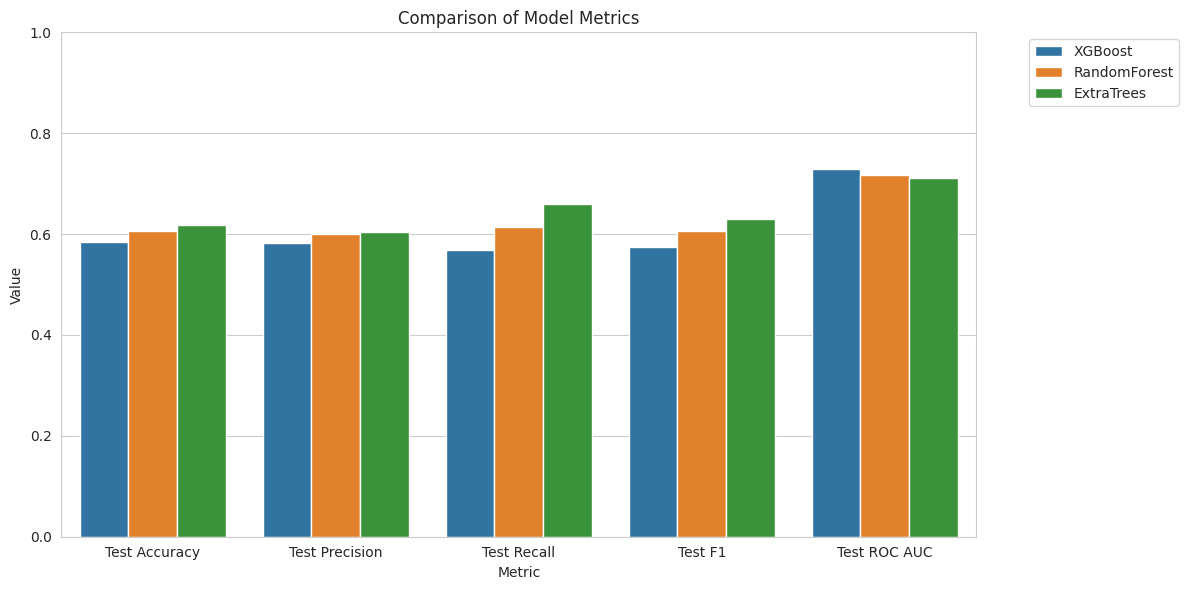

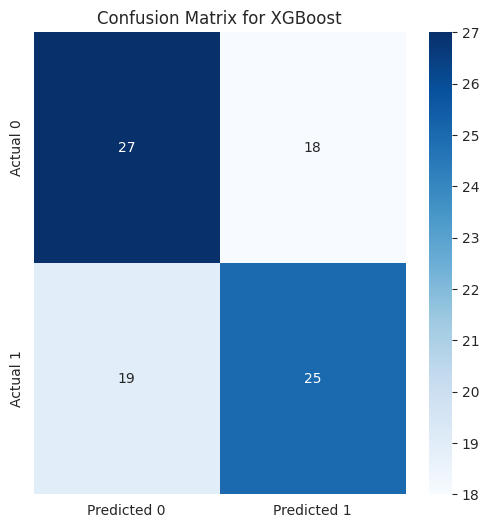

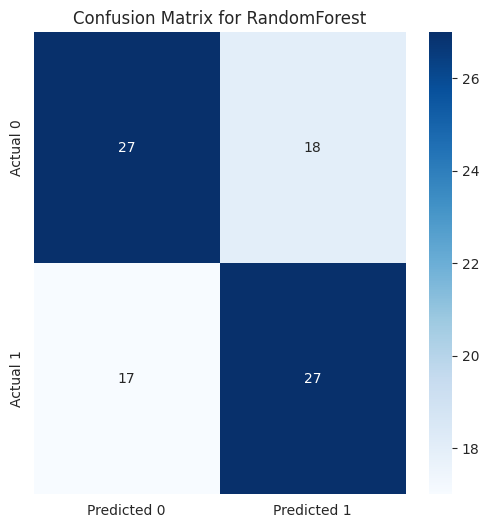

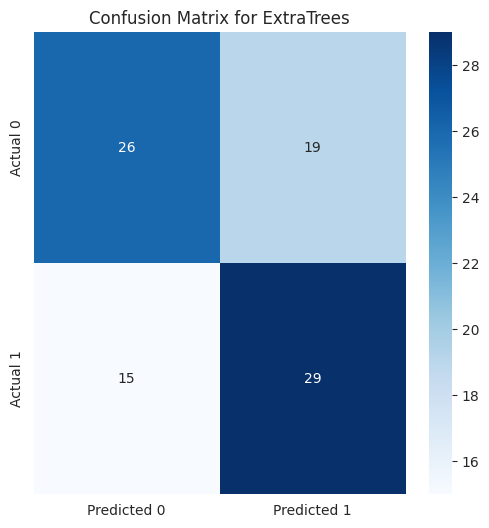

In [ ]:
# Инициализация и оценка моделей
evaluator = ClassificationModelEvaluatorOptuna(X1, y1, n_trials=200)
results = evaluator.evaluate_models(verbose=True)

# Вывод результатов
print("\nResults:")
print(results[['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1', 'Test ROC AUC', 'Best Parameters']])

# Визуализация результатов
evaluator.plot_metrics_comparison()
plt.show()

# Визуализация для конкретной модели (например, XGBoost)
evaluator.plot_optimization_history('XGBoost').show()
evaluator.plot_optimization_history('RandomForest').show()
evaluator.plot_optimization_history('ExtraTrees').show()
evaluator.plot_param_importances('XGBoost').show()
evaluator.plot_param_importances('RandomForest').show()
evaluator.plot_param_importances('ExtraTrees').show()
evaluator.plot_confusion_matrix('XGBoost')
evaluator.plot_confusion_matrix('RandomForest')
evaluator.plot_confusion_matrix('ExtraTrees')
plt.show()

In [ ]:
# @title Сохранение лучшей модели

evaluator.save_model('RandomForest', 'IC50_class_RF_model.pkl')
evaluator_pca_cleaned.save_model('RandomForest', 'IC50_class_RF_model.pkl')

Модель RandomForest сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_class_RF_model.pkl
